Build a simple end-to-end machine learning application that predicts a student’s final grade
based on the number of hours spent studying after the midterm and the student’s midterm score.
The application should include a backend API and a frontend interface.

I could not find a dataset that satisfied the requirements for this problem, so I created my own. From looking up how these variables typically relate, students with higher midterm scores usually end up with higher final grades, and the opposite is often true for students with lower midterm scores. Taking this into account, I made the midterm score weigh heavily in the final grade calculation, with an added contribution based on hours studied after the midterm. I also included a baseline offset and some noise to make the data less perfectly predictable. Using this approach, I generated a synthetic dataset of 900 students.

In [17]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_students = 900
student_ids = [str(i).zfill(4) for i in range(1, n_students + 1)]

# Midterm is any random number from 0 to 100
midterm_scores = np.random.uniform(0, 100, n_students)

# Study hours are between 0 and 15
study_hours = np.random.uniform(0, 15, n_students)

# Noise so it's not perfectly predictable
noise = np.random.normal(0, 5, n_students)

# Final grade:
# - midterm is still the main driver
# - hours matter more now (0-15 range, so the coefficient is higher)
# - baseline keeps scores from being too low overall
final_grades = (
    0.70 * midterm_scores
    + 1.7 * study_hours
    + 10
    + noise
)

final_grades = final_grades.clip(0, 100)

df = pd.DataFrame({
    "Student_ID": student_ids,
    "Midterm_Score": np.round(midterm_scores, 1),
    "Hours_Studied": np.round(study_hours, 1),
    "Final_Grade": np.round(final_grades, 1)
})

df.to_csv("student_performance.csv", index=False)

Now that the dataset is generated, I wanted to visualize the data to better understand the relationships between the features and the target variable, and to help determine what baseline model would be appropriate to use.

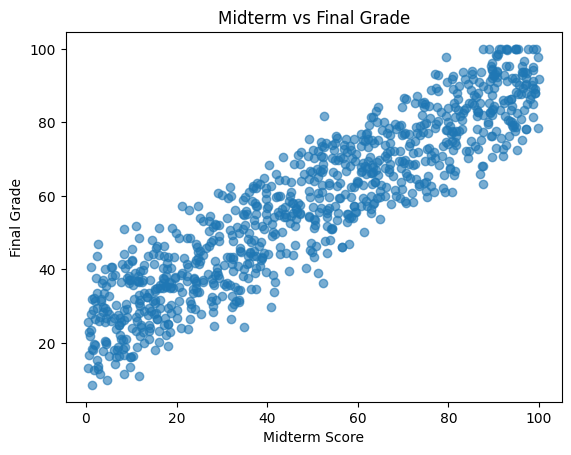

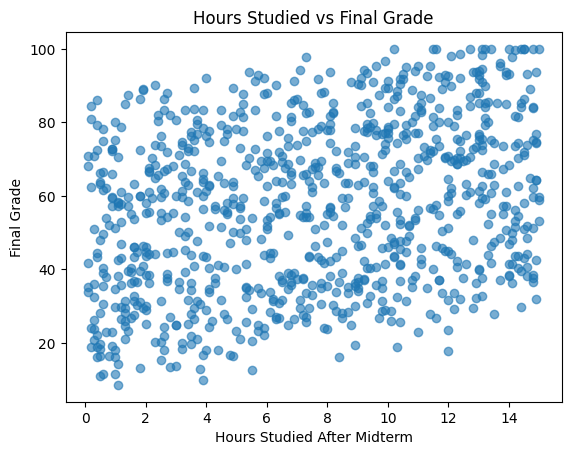

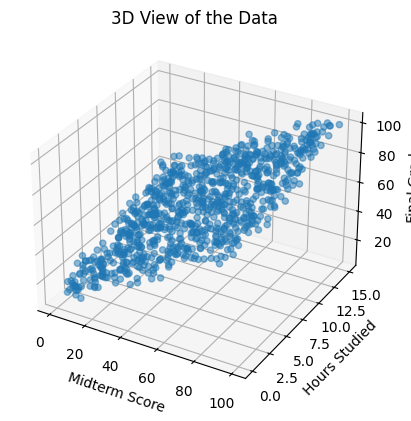

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df["Midterm_Score"], df["Final_Grade"], alpha=0.6)
plt.xlabel("Midterm Score")
plt.ylabel("Final Grade")
plt.title("Midterm vs Final Grade")
plt.show()

plt.figure()
plt.scatter(df["Hours_Studied"], df["Final_Grade"], alpha=0.6)
plt.xlabel("Hours Studied After Midterm")
plt.ylabel("Final Grade")
plt.title("Hours Studied vs Final Grade")
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    df["Midterm_Score"],
    df["Hours_Studied"],
    df["Final_Grade"],
    alpha=0.5
)

ax.set_xlabel("Midterm Score")
ax.set_ylabel("Hours Studied")
ax.set_zlabel("Final Grade")
ax.set_title("3D View of the Data")

plt.show()



Looking at the data, both midterm score and hours studied show a largely linear relationship with the final grade. Because of this, linear regression is an appropriate baseline model. In a typical workflow, the data might require preprocessing or feature engineering, but since this dataset was generated in a controlled way, it is already clean and properly scaled, so no additional preprocessing was necessary.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[["Midterm_Score", "Hours_Studied"]]
y = df["Final_Grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

print("Intercept:", model.intercept_)
print("Coefficients:")
for name, coef in zip(X.columns, model.coef_):
    print(f"  {name}: {coef:.3f}")


RMSE: 4.65
R²: 0.954
Intercept: 10.31717097536361
Coefficients:
  Midterm_Score: 0.699
  Hours_Studied: 1.666


The results show that the model is able to predict final grades with an average error of around 5 points. The learned intercept and coefficients are also very close to the values that were used to generate the dataset, which indicates that the model was able to recover the underlying relationship between the inputs and the target.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


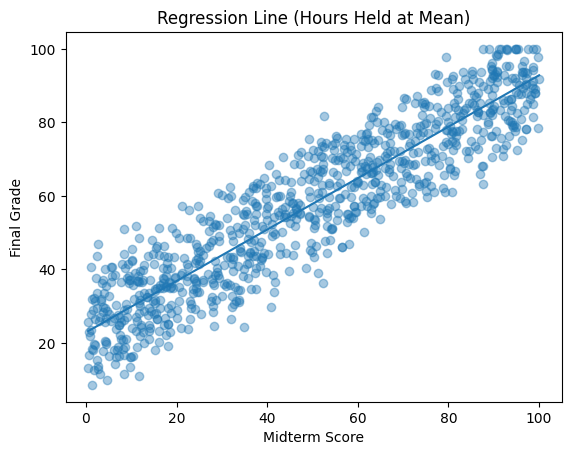

In [29]:
import numpy as np
import matplotlib.pyplot as plt

midterm_range = np.linspace(
    df["Midterm_Score"].min(),
    df["Midterm_Score"].max(),
    100
)

mean_hours = df["Hours_Studied"].mean()

X_line = np.column_stack([
    midterm_range,
    np.full_like(midterm_range, mean_hours)
])

y_line = model.predict(X_line)

plt.figure()
plt.scatter(df["Midterm_Score"], df["Final_Grade"], alpha=0.4)
plt.plot(midterm_range, y_line)
plt.xlabel("Midterm Score")
plt.ylabel("Final Grade")
plt.title("Regression Line (Hours Held at Mean)")
plt.show()


This plot shows the linear regression fit for midterm score and hours studied after the midterm relative to the final grade. Although not shown in the notebook, ridge and lasso regression were also tested and did not significantly change the learned relationship or improve performance. Because of this, linear regression was chosen as the final model. We will save the trained model so it can be reused later without retraining.

In [33]:
import joblib

model_bundle = {
    "model": model,
    "features": ["Midterm_Score", "Hours_Studied"]
}

joblib.dump(model_bundle, "final_grade_model.pkl")


['final_grade_model.pkl']